In [1]:
import matplotlib
%matplotlib nbagg
from matplotlib import pyplot

In [2]:
from statiskit import (linalg,
                       core,
                       pgm)

In [3]:
import math
import os

In [4]:
%reload_ext rpy2.ipython

In [5]:
%%R
library(glasso)

In [6]:
if not 'K' in os.environ:
    os.environ['K'] = str(10)
K = int(os.environ.get('K'))
simulation = !jupyter nbconvert --ExecutePreprocessor.timeout=3600 --to notebook --execute sampling.ipynb --output sampling.ipynb
data = core.read_csv('data.csv')

In [6]:
LASSO <- function(data, penality){
  
  d = length(data)
  sigma <- cov(data)
  #penalitÃŠ linÃŠaire
  if (penality == "LINEAIR")
    lamda <- seq(0.001,max(sigma),length.out = 1+d*(d+1)/2)
  #penalitÃŠ avec les val de sigma
  else 
    lamda <- c(sigma[ upper.tri(sigma,diag = FALSE) ],0.001)
  
  lamda <- sort(abs(lamda),decreasing = TRUE)
  
  ############ON TOURNE LE LASSO POUR CHAQUE LAMDA##########
  j=1
  for(i in lamda){
    
    lasso.res  <- glasso(sigma,rho =i)
    write.table(lasso.res$wi, paste("lasso_", j, ".csv", sep=''), row.names=FALSE,col.names = FALSE, sep =" ")
    j=j+1
  }
}

In [7]:
if not 'LASSO' in os.environ:
    os.environ['LASSO'] = "linear"
LASSO = os.environ.get('LASSO')
if not 'PENALTIES' in os.environ:
    os.environ['PENALTIES'] = str(K)
PENALTIES = int(os.environ.get('PENALTIES'))

In [12]:
import itertools
import numpy
import math
S = data.covariance
for u in range(K):
    S[u, u] = float("nan")
    for v in range(u):
        S[u, v] = math.fabs(S[u, v])
        S[v, u] = S[u, v]
rhos = core.from_list(list(itertools.chain(*S.to_list())))
LASSO = 'empirical'
if LASSO == 'linear':
    rhos = numpy.linspace(rhos.min.value, rhos.max.value, PENALTIES).tolist()
elif LASSO == 'empirical':
    freq = core.frequency_estimation(data=rhos)
    rhos = [freq.estimated.quantile(rho) for rho in numpy.linspace(0., 1., PENALTIES)]
else:
    raise ValueError("'LASSO' environment variable")

[0.012621417255249012,
 0.0396490769623321,
 0.06275144540631682,
 0.08039576788239222,
 0.14986998738388196,
 0.23563810568597068,
 0.3483856895349121,
 0.4547778738123868,
 0.5738151639971686,
 1.1653257112459352]

In [15]:
%R data = read.csv('data.csv', header = F, sep="") 
%R -n S = cov(data)

In [27]:
graphs = []
for rho in [0.1, 0.2]:
    %R -i rho
    theta = %R glasso(S, rho=rho)$wi
    graphs.append(pgm.UndirectedGraph(linalg.Matrix(theta)))
graphs = sorted(graphs, key = lambda graph: graph.nb_edges)

In [34]:
if not 'CRITERION' in os.environ:
    os.environ['CRITERION'] = "SH"
CRITERION = os.environ.get('CRITERION')

In [35]:
logL = []
for graph in graphs:
    try:
        mle = pgm.graphical_gaussian_estimation(algo='scd',
                                                data=data,
                                                graph=graph)
        logL.append(2 *  mle.estimated.loglikelihood(data))
    except:
        logL.append(float("nan"))

<IPython.core.display.Javascript object>


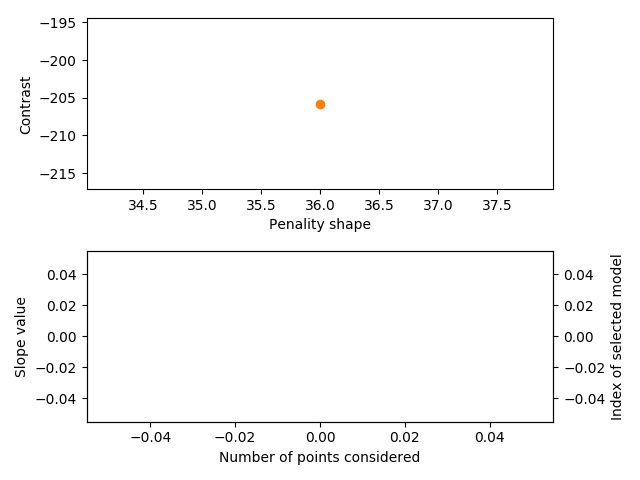

In [46]:
dimensions = [graph.nb_edges + 2 * graph.nb_vertices for graph in graphs]
fig = pyplot.figure()
if not CRITERION == 'SH':
    total, dimensions = data.total, 
    if CRITERION == 'BIC':
        import math
        logL = [logl - 2 * dimension * math.log(total) for logl, dimension in zip(logL, dimensions)]
    elif CRITERION == 'AIC':
        logL = [logl - 2 * dimension for logl, dimension in zip(logL, dimensions)]
    elif CRITERION == 'AICc':
        logL = [logl - 2 * dimension * (dimension + 1) / (total - dimension -1) for logl, dimension in zip(logL, dimensions)]
    else:
        raise ValueError("'CRITERION' environment variable")
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(dimensions, logL)
    index = logL.index(max(LogL))
else:
    sh = core.SlopeHeuristic(dimensions, logL)
    sh.plot()
    index = sh.selector(sh)
pyplot.tight_layout()

<IPython.core.display.Javascript object>


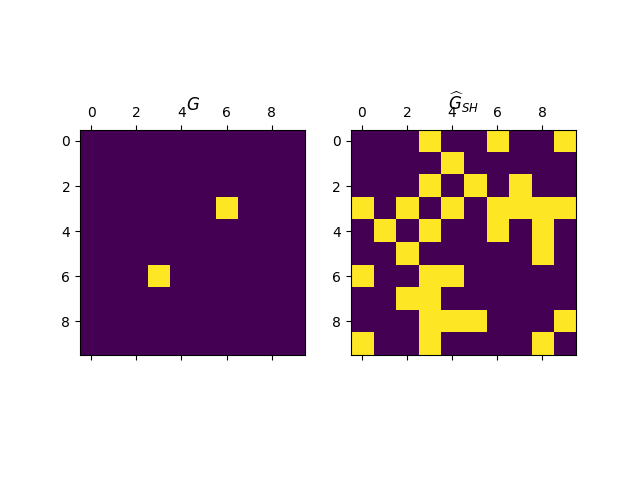

In [49]:
fig = pyplot.figure()
truth = pgm.read_gml('graph.gml')
axes =  truth.to_matrix().plot(axes = fig.add_subplot(121))
axes.set_title('$G$')
axes = graphs[index].to_matrix().plot(axes = fig.add_subplot(122))
axes.set_title('$\widehat{G}_{' + CRITERION + '}$')

In [13]:
def TP(truth, predicted):
    tp = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if truth.has_edge(u, v) and predicted.has_edge(u, v):
                tp += 1
    return tp

def TN(truth, predicted):
    tn = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if not truth.has_edge(u, v) and not predicted.has_edge(u, v):
                tn += 1
    return tn

def FP(truth, predicted):
    fp = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if truth.has_edge(u, v) and not predicted.has_edge(u, v):
                fp += 1
    return fp

def FN(truth, predicted):
    fn = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if not truth.has_edge(u, v) and predicted.has_edge(u, v):
                fn += 1
    return fn
tp, tn, fp, fn = TP(tr, graph), TN(graph0, graph), FP(graph0, graph), FN(graph0, graph)
(tp, tn, fp, fn)

(2, 5, 0, 18)

In [14]:
import hashlib
identifier = hashlib.md5(str(graph0)).hexdigest()
with open('paths.csv', 'a') as filehandler:
    for graph in graphs:
        tp, tn, fp, fn = TP(truth, graph), TN(truth, graph), FP(truth, graph), FN(truth, graph)
        filehandler.write(','.join([identifier, str(K), str(LAMBDA), str(tp), str(tn), str(fp), str(fn)]) + '\n')

In [16]:
with open('criteria.csv', 'a') as filehandler:
    tp, tn, fp, fn = TP(truth, graphs[index]), TN(truth, graphs[index]), FP(truth, graphs[index]), FN(truth, graphs[index])
    filehandler.write(','.join([str(K), str(CRITERION), str(tp), str(tn), str(fp), str(fn)]) + '\n')

In [17]:
os.remove('graph.gml')
os.remove('data.csv')